In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
calib_txt = "/home/dexter/Personal/stereo-triangulator/data/calib/000000.txt"

with open(calib_txt, "r") as f:
    lines = f.readlines()

    for line in lines:
        if line.startswith("P_rect_02"):
            print(line)

    for line in lines:
        if line.startswith("P_rect_02"):
            arr_elements_str = line.split(":")[1].strip()
            P2 = np.float64(arr_elements_str.split(" ")).reshape(3, 4)

    for line in lines:
        if line.startswith("P_rect_03"):
            print(line)

    for line in lines:
        if line.startswith("P_rect_03"):
            arr_elements_str = line.split(":")[1].strip()
            P3 = np.float64(arr_elements_str.split(" ")).reshape(3, 4)

P_rect_02: 7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01 0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01 0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03

P_rect_03: 7.215377e+02 0.000000e+00 6.095593e+02 -3.395242e+02 0.000000e+00 7.215377e+02 1.728540e+02 2.199936e+00 0.000000e+00 0.000000e+00 1.000000e+00 2.729905e-03



In [4]:
P2

array([[7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01],
       [0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01],
       [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]])

In [5]:
P3

array([[ 7.215377e+02,  0.000000e+00,  6.095593e+02, -3.395242e+02],
       [ 0.000000e+00,  7.215377e+02,  1.728540e+02,  2.199936e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  2.729905e-03]])

In [6]:
fx, cx, cy = P2[0,0], P2[0,2], P2[1,2]
Tx = P3[0,3]

In [7]:
fx

np.float64(721.5377)

In [9]:
cx

np.float64(609.5593)

In [10]:
cy

np.float64(172.854)

In [11]:
Tx

np.float64(-339.5242)

In [14]:
B = -Tx / fx
B

np.float64(0.47055642414803833)

In [15]:
print("fx,cx,cy=", fx, cx, cy)
print("Baseline B (m) =", B)

fx,cx,cy= 721.5377 609.5593 172.854
Baseline B (m) = 0.47055642414803833


In [16]:
Q = np.array([
    [1, 0, 0, -cx],
    [0, 1, 0, -cy],
    [0, 0, 0, fx],
    [0, 0, -1.0 / B, 0]
], dtype=np.float64)

Q

array([[   1.        ,    0.        ,    0.        , -609.5593    ],
       [   0.        ,    1.        ,    0.        , -172.854     ],
       [   0.        ,    0.        ,    0.        ,  721.5377    ],
       [   0.        ,    0.        ,   -2.12514366,    0.        ]])

In [18]:
left_image = cv2.imread("/home/dexter/Personal/stereo-triangulator/data/image_2/000000_10.png")
right_image = cv2.imread("/home/dexter/Personal/stereo-triangulator/data/image_3/000000_10.png")

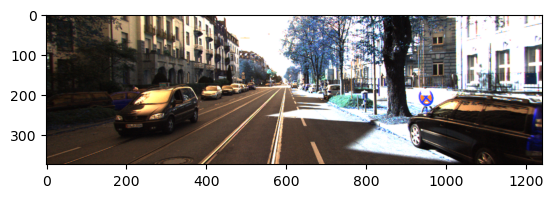

In [28]:
%matplotlib inline
plt.imshow(left_image)

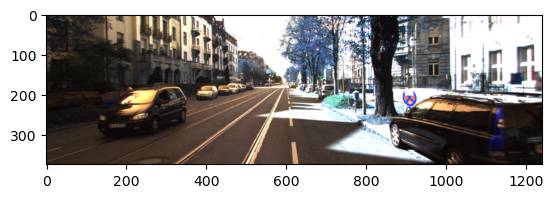

In [29]:
plt.imshow(right_image)

In [30]:
left_gray = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

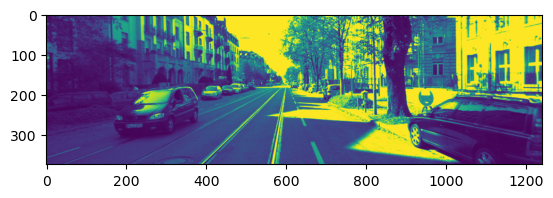

In [31]:
plt.imshow(left_gray)

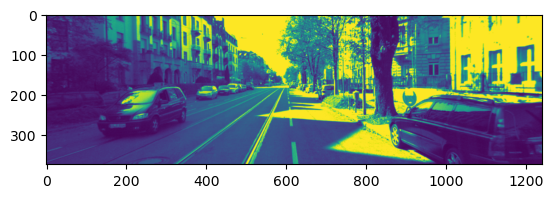

In [32]:
plt.imshow(right_gray)

In [33]:
min_disp = 0
num_disp = 192
blockSize = 5

In [34]:
def compute_disparity_sgbm(left_gray, right_gray, min_disp=0, num_disp=192, block_size=5):
    matcher = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=block_size,
        P1=8*3*block_size**2,
        P2=32*3*block_size**2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=2,
        disp12MaxDiff=1,
    )

    disp = matcher.compute(left_gray, right_gray).astype(np.float32) / 16.0
    return disp

In [35]:
disp = compute_disparity_sgbm(left_gray, right_gray, min_disp=min_disp, num_disp=num_disp, block_size=blockSize)

In [36]:
disp

array([[-1.    , -1.    , -1.    , ..., 20.875 , 20.875 , 20.875 ],
       [-1.    , -1.    , -1.    , ..., 20.875 , 20.875 , 20.875 ],
       [-1.    , -1.    , -1.    , ..., 20.9375, 20.9375, 20.875 ],
       ...,
       [-1.    , -1.    , -1.    , ..., 96.8125, -1.    , -1.    ],
       [-1.    , -1.    , -1.    , ..., 96.4375, -1.    , -1.    ],
       [-1.    , -1.    , -1.    , ..., 96.375 , -1.    , -1.    ]],
      shape=(375, 1242), dtype=float32)

In [37]:
points_3d = cv2.reprojectImageTo3D(disp, Q)

In [38]:
points_3d

array([[[-286.83206  ,  -81.33756  ,  339.5242   ],
        [-286.3615   ,  -81.33756  ,  339.5242   ],
        [-285.89093  ,  -81.33756  ,  339.5242   ],
        ...,
        [ -14.188616 ,    3.8964102,  -16.264633 ],
        [ -14.211158 ,    3.8964102,  -16.264633 ],
        [ -14.233699 ,    3.8964102,  -16.264633 ]],

       [[-286.83206  ,  -80.867004 ,  339.5242   ],
        [-286.3615   ,  -80.867004 ,  339.5242   ],
        [-285.89093  ,  -80.867004 ,  339.5242   ],
        ...,
        [ -14.188616 ,    3.8738685,  -16.264633 ],
        [ -14.211158 ,    3.8738685,  -16.264633 ],
        [ -14.233699 ,    3.8738685,  -16.264633 ]],

       [[-286.83206  ,  -80.39645  ,  339.5242   ],
        [-286.3615   ,  -80.39645  ,  339.5242   ],
        [-285.89093  ,  -80.39645  ,  339.5242   ],
        ...,
        [ -14.146261 ,    3.8398304,  -16.216082 ],
        [ -14.1687355,    3.8398304,  -16.216082 ],
        [ -14.233699 ,    3.851327 ,  -16.264633 ]],

       ...,

      

In [39]:
disp.shape

(375, 1242)

In [41]:
print("disp min/max:", np.nanmin(disp), np.nanmax(disp))

disp min/max: -1.0 105.3125


In [43]:
disp_vis = disp.copy()
disp_vis[~np.isfinite(disp_vis)] = 0
m, M = disp_vis.min(), disp_vis.max()
disp_norm = ((disp_vis - m) / (M - m + 1e-6) * 255).astype(np.uint8)
cv2.imwrite("../out/000000_10_disparity.png", disp_norm)

True

In [45]:
gt_path = "/media/dexter/PortableSSD/Datasets/KITTI/Stereo 2015/data_scene_flow/training/disp_noc_0/000000_10.png"
gt = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
gt = gt / 256.0

# valid mask (0 = invalid/no ground truth)
valid = gt > 0

In [47]:
# End-Point Error

epe = np.mean(np.abs(disp[valid] - gt[valid]))
print("EPE:", epe)

EPE: 5.0483885


In [48]:
# Bad Pixel 3.0 (Bad-3%)

bad3 = np.mean(np.abs(disp[valid] - gt[valid]) > 3.0) * 100
print("Bad-3%:", bad3)

Bad-3%: 17.409248449470997


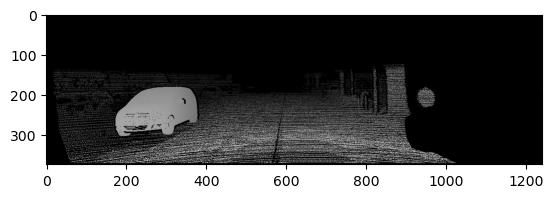

In [53]:
# GT Visualisation
gt_vis = (gt / gt.max() * 255).astype(np.uint8)
cv2.imwrite("../out/gt_vis.png", gt_vis)

plt.imshow(gt_vis, cmap="gray")

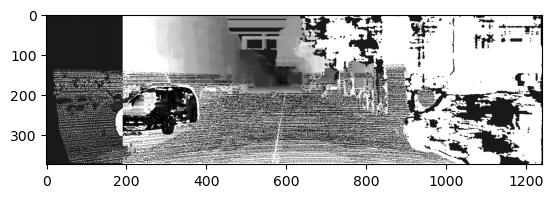

In [54]:
# Error heatmap

error = np.abs(disp - gt)
err_vis = np.clip(error / 10.0 * 255, 0, 255).astype(np.uint8)
cv2.imwrite("../out/error_heatmap.png", err_vis)

plt.imshow(err_vis, cmap="gray")